In [ ]:
!nvidia-smi

Fri Apr 28 14:34:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0    31W /  70W |    621MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install torchsummaryX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import torch
import os
import gc
from tqdm import tqdm
import numpy as np
import scipy
from torchsummaryX import summary
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cuda


In [57]:
class SUNDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, mode="train"):
      self.root_dir = root_dir
      self.xs = np.loadtxt(os.path.join(root_dir, f"{mode}_files.txt"), delimiter="\n", dtype="str")
      self.ys = np.loadtxt(os.path.join(root_dir, f"{mode}_labels.txt"), delimiter="\n")
      self.img_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
      ])

    def __len__(self):
        return len(self.xs)
    
    def __getitem__(self, idx):
      with Image.open(os.path.join(self.root_dir, self.xs[idx])) as img:
        img = self.img_transform(img)
        if img.shape[0] == 1:
          img = img.repeat(3, 1, 1)
        label = self.ys[idx]
        return img, label

In [4]:
root_dir = "./data"

In [40]:
max_iters = 15
batch_size = 128
learning_rate = 5e-3

In [58]:
train_dataset = SUNDataset(root_dir, mode="train")
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True,
    drop_last=False,
)

test_dataset = SUNDataset(root_dir, mode="test")
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,
    drop_last=False,
)

In [23]:
class ConvNet(torch.nn.Module):
  def __init__(self, in_channels=3, output_size=8):
     super(ConvNet, self).__init__()
     self.backbone = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=2, padding=3),
        torch.nn.BatchNorm2d(64),
        torch.nn.GELU(),
        torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=2, padding=3),
        torch.nn.BatchNorm2d(128),
        torch.nn.GELU()
      )
     self.head = torch.nn.Sequential(
         torch.nn.Flatten(),
         torch.nn.Linear(in_features=128*66*66, out_features=128),
         torch.nn.BatchNorm1d(num_features=128),
         torch.nn.GELU(),
         torch.nn.Dropout(p=0.2),
         torch.nn.Linear(in_features=128, out_features=output_size)
     )
  
  def forward(self, x):
    embedding = self.backbone(x)
    out = self.head(embedding)
    return out


In [41]:
convmodel = ConvNet().to(device)
imgs, labels = next(iter(train_loader))
summary(convmodel, imgs.to(device))

                             Kernel Shape         Output Shape      Params  \
Layer                                                                        
0_backbone.Conv2d_0         [3, 64, 3, 3]  [128, 64, 130, 130]      1.792k   
1_backbone.BatchNorm2d_1             [64]  [128, 64, 130, 130]       128.0   
2_backbone.GELU_2                       -  [128, 64, 130, 130]           -   
3_backbone.Conv2d_3       [64, 128, 5, 5]   [128, 128, 66, 66]    204.928k   
4_backbone.BatchNorm2d_4            [128]   [128, 128, 66, 66]       256.0   
5_backbone.GELU_5                       -   [128, 128, 66, 66]           -   
6_head.Flatten_0                        -        [128, 557568]           -   
7_head.Linear_1             [557568, 128]           [128, 128]  71.368832M   
8_head.BatchNorm1d_2                [128]           [128, 128]       256.0   
9_head.GELU_3                           -           [128, 128]           -   
10_head.Dropout_4                       -           [128, 128]  

/usr/local/lib/python3.10/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_backbone.Conv2d_0,"[3, 64, 3, 3]","[128, 64, 130, 130]",1792.0,29203200.0
1_backbone.BatchNorm2d_1,[64],"[128, 64, 130, 130]",128.0,64.0
2_backbone.GELU_2,-,"[128, 64, 130, 130]",NaN,NaN
3_backbone.Conv2d_3,"[64, 128, 5, 5]","[128, 128, 66, 66]",204928.0,892108800.0
4_backbone.BatchNorm2d_4,[128],"[128, 128, 66, 66]",256.0,128.0
5_backbone.GELU_5,-,"[128, 128, 66, 66]",NaN,NaN
6_head.Flatten_0,-,"[128, 557568]",NaN,NaN
7_head.Linear_1,"[557568, 128]","[128, 128]",71368832.0,71368704.0
8_head.BatchNorm1d_2,[128],"[128, 128]",256.0,128.0


In [42]:
def train(model, optimizer, criterion, dataloader):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    total_instances = 0
    for iter, (xb, yb) in enumerate(dataloader):
      xb = xb.to(device)
      yb = yb.type(torch.LongTensor)
      yb = yb.to(device)
      
      logits = model(xb)
      loss = criterion(logits, yb)
      
      train_loss += loss.item()
      train_acc += (torch.argmax(logits, dim=1) == yb).sum().item()
      
      optimizer.zero_grad()
      
      loss.backward()
      optimizer.step()

      total_instances += len(xb)

    train_loss /= len(dataloader)
    train_acc /= total_instances
    return train_loss, train_acc

In [43]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(convmodel.parameters(), lr=learning_rate, weight_decay=0.01,)

In [44]:
torch.cuda.empty_cache()
best_acc = 0.0

train_losses = []
train_accs = []

checkpoint_path = "./sun_model_checkpoint.pth"

for epoch in tqdm(range(max_iters)):
    train_loss, train_accuracy = train(convmodel, optimizer, criterion, train_loader)
    
    train_losses.append(train_loss)
    train_accs.append(train_accuracy)

    print("Epoch {}/{} | Train Loss: {:.4f} | Train Accuracy: {:.2f}".format(epoch+1, max_iters, train_loss, train_accuracy))
    if train_accuracy > best_acc:
      best_acc = train_accuracy
      torch.save({
          "epoch": epoch,
          "model_state_dict": convmodel.state_dict(),
          "optimizer_state_dict": optimizer.state_dict(),
          "loss": train_loss,
          "train_acc": train_accuracy}, checkpoint_path)


  0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1/15 | Train Loss: 1.4203 | Train Accuracy: 0.49


  7%|▋         | 1/15 [00:11<02:40, 11.46s/it]

Epoch 2/15 | Train Loss: 0.9891 | Train Accuracy: 0.66


 13%|█▎        | 2/15 [00:22<02:28, 11.39s/it]

Epoch 3/15 | Train Loss: 0.8120 | Train Accuracy: 0.73


 20%|██        | 3/15 [00:34<02:16, 11.36s/it]

Epoch 4/15 | Train Loss: 0.7773 | Train Accuracy: 0.74


 33%|███▎      | 5/15 [00:52<01:37,  9.70s/it]

Epoch 5/15 | Train Loss: 0.7245 | Train Accuracy: 0.74
Epoch 6/15 | Train Loss: 0.6204 | Train Accuracy: 0.79


 40%|████      | 6/15 [01:03<01:32, 10.25s/it]

Epoch 7/15 | Train Loss: 0.5922 | Train Accuracy: 0.80


 47%|████▋     | 7/15 [01:14<01:25, 10.64s/it]

Epoch 8/15 | Train Loss: 0.4885 | Train Accuracy: 0.85


 53%|█████▎    | 8/15 [01:26<01:15, 10.85s/it]

Epoch 9/15 | Train Loss: 0.4317 | Train Accuracy: 0.86


 60%|██████    | 9/15 [01:37<01:05, 11.00s/it]

Epoch 10/15 | Train Loss: 0.3431 | Train Accuracy: 0.90


 67%|██████▋   | 10/15 [01:48<00:55, 11.02s/it]

Epoch 11/15 | Train Loss: 0.2894 | Train Accuracy: 0.91


 73%|███████▎  | 11/15 [01:59<00:43, 10.96s/it]

Epoch 12/15 | Train Loss: 0.2406 | Train Accuracy: 0.93


 87%|████████▋ | 13/15 [02:17<00:19,  9.88s/it]

Epoch 13/15 | Train Loss: 0.2191 | Train Accuracy: 0.93
Epoch 14/15 | Train Loss: 0.1908 | Train Accuracy: 0.95


 93%|█████████▎| 14/15 [02:28<00:10, 10.30s/it]

Epoch 15/15 | Train Loss: 0.1547 | Train Accuracy: 0.95


100%|██████████| 15/15 [02:40<00:00, 10.68s/it]


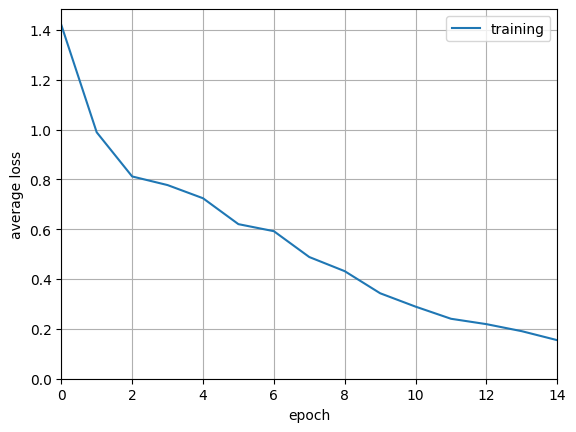

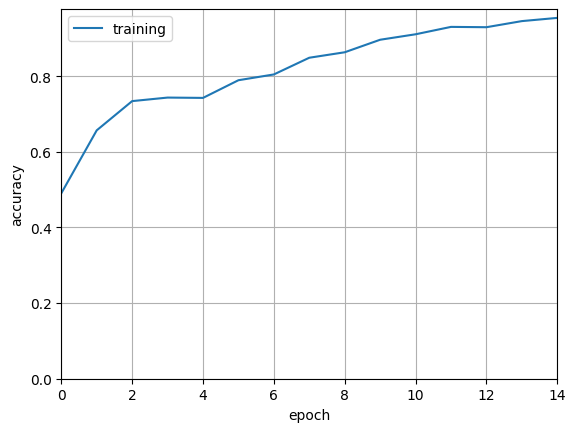

In [45]:
# plot loss curves
plt.plot(range(len(train_losses)), train_losses, label="training")
plt.xlabel("epoch")
plt.ylabel("average loss")
plt.xlim(0, len(train_losses) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

# plot accuracy curves
plt.plot(range(len(train_accs)), train_accs, label="training")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.xlim(0, len(train_accs) - 1)
plt.ylim(0, None)
plt.legend()
plt.grid()
plt.show()

In [47]:
model = ConvNet(in_channels=3, output_size=8).to(device)
model_state_dict_path = torch.load(checkpoint_path)
model.load_state_dict(model_state_dict_path["model_state_dict"])

<All keys matched successfully>

In [61]:
def eval(model, criterion, dataloader):
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    total_instances = 0
    with torch.inference_mode():
      for i, (xb, yb) in enumerate(dataloader):
        xb = xb.to(device)
        yb = yb.type(torch.LongTensor)
        yb = yb.to(device)
        
        logits = model(xb)
        loss = criterion(logits, yb)
        
        val_loss += loss.item()
        val_acc += (torch.argmax(logits, dim=1) == yb).sum().item()
        total_instances += len(xb)

    val_loss /= len(dataloader)
    val_acc /= total_instances
    return val_loss, val_acc

_, test_accuracy = eval(model, criterion, test_loader)
print("SUN Conv Model Test Accuracy: {:.2f}%".format(test_accuracy))

SUN Conv Model Test Accuracy: 0.70%
